In [1]:
import time
start_time=time.time()

In [2]:
import sys
from pathlib import Path
import json
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import strucfunc
from strucfunc import sosflog
import bfunc

In [3]:
# Input fit files

flux    = fits.open('linesum-H_I-6563.fits')
rad_vel = fits.open('mean-H_I-6563-patfixx.fits')

In [4]:
# Region propertires
dist   = 410   # distance [parsecs]
pix    = 0.2 # spatialscale [arcsec per pixel]

# Observation propertires
seeing = 0.9   # FWHM seeing [arcsec] 

# Conversions
pc = dist * ( 2 * np.pi ) / (360 * 60 * 60) # value in parsecs of each arcsec
s0 = (seeing  * pc) / 2.355 # RMS seeing [parsecs]
pc , s0

(0.0019877360925490972, 0.0007596443665792729)

In [5]:
sb = flux[0].data.astype(float)
vv = rad_vel[0].data.astype(float)

In [6]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

good = (~m) & (sb > 0.001)

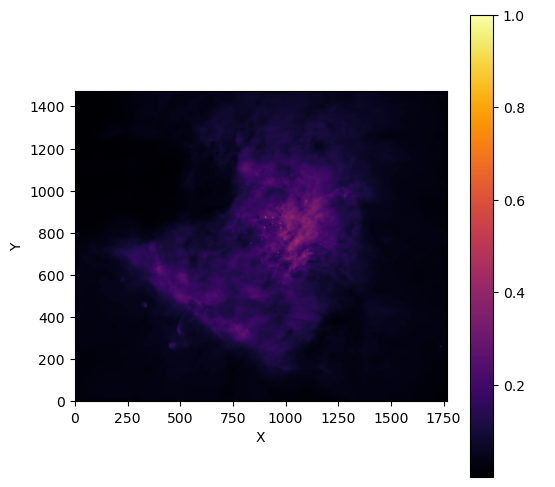

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

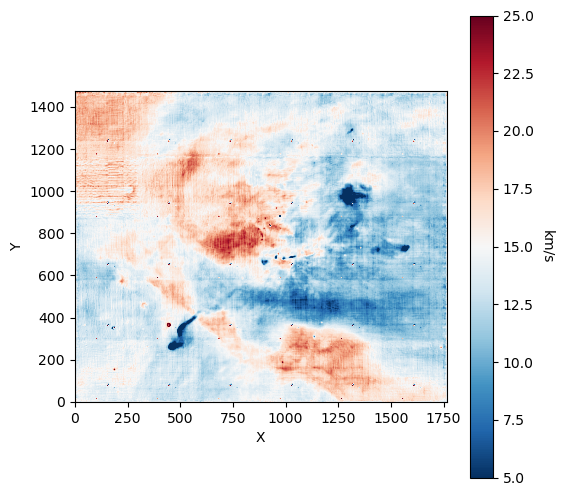

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.figure(1)
plt.imshow(vv, cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(5,25)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [9]:
box_size = np.sqrt(sb.shape[0] * sb.shape[1]) * pix * pc

In [10]:
rslt = strucfunc.strucfunc_numba_parallel(vv, wmap=sb, dlogr=0.05)

C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\strucfunc.py:83: RuntimeWarning: invalid value encountered in divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Dropbox\GitHub\orion_muse\strucfunc.py:84: RuntimeWarning: invalid value encountered in divide
  'Weighted B(r)': wsf/weight}


In [11]:
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [13]:
b2 = rslt['Unweighted B(r)']
b2w = rslt['Weighted B(r)']
e_b2 = b2  *.1
e_b2w = b2w  *.1

s = 10**rslt['log10 r'] * pix * pc
e_s = s  *.1
sig2 = rslt['Unweighted sigma^2']
sig2w = rslt['Weighted sigma^2']

sig = sig2**0.5

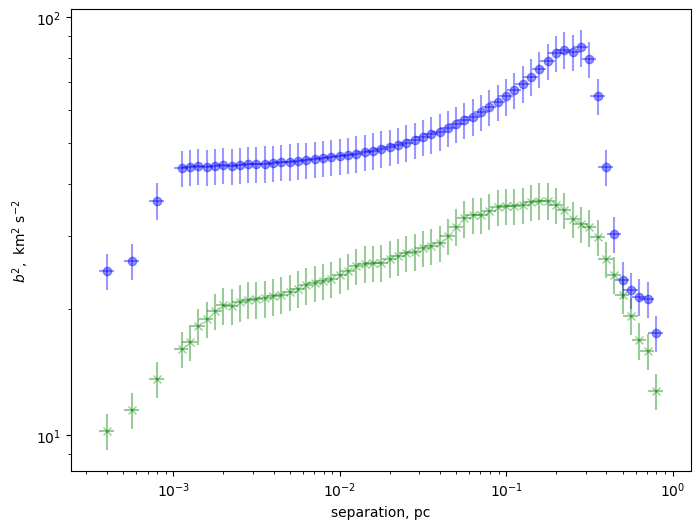

In [16]:
m = 1.2
noise = 0.01


fig, ax = plt.subplots(figsize=(8, 6))
rgrid = np.logspace(-3, .1)
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.4,color="blue")
ax.errorbar(s, b2w, yerr=e_b2w, xerr=e_s, fmt='x', alpha=0.4,color="green")

ax.set(xscale='log', yscale='log', 
       xlabel='separation, pc',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

#sig2, r0, m

In [17]:
results = {
    'sig2' : sig2,
          } 

In [20]:
data_export = {   
        's' : s,
        'b2' : b2,
    
        'pc' : pc,
        'pix' : pix,
        'box_size': box_size,
         'results':results,
         'SF' : rslt,
            'SB' : sb,
         'VF' : vv,
}

In [22]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [23]:
jsonfilename = "H_I-6563.json"
with open(jsonfilename, "w") as f:
    json.dump(data_export, fp=f, indent=3, cls=MyEncoder)

In [24]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 29933.496121644974 seconds ---
